In [ ]:
import pandas as pd

In [ ]:
from numpy import split
from numpy import array
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,RepeatVector,TimeDistributed

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
train, test = serie_2004_2007[1:-6600], serie_2004_2007[-6600:]

In [ ]:
print(test)

                           PUN   CNOR   CSUD   NORD   SARD    SICI    SUD
data_ora_series                                                          
2007-04-01 00:00:00  75.245325  75.01  75.01  75.01  75.01   78.53  75.01
2007-04-01 01:00:00  47.573304  47.57  47.57  47.57  47.57   47.62  47.57
2007-04-01 02:00:00  34.700000  34.70  34.70  34.70  34.70   34.70  34.70
2007-04-01 03:00:00  34.690000  34.69  34.69  34.69  34.69   34.69  34.69
2007-04-01 04:00:00  28.700000  28.70  28.70  28.70  28.70   28.70  28.70
...                        ...    ...    ...    ...    ...     ...    ...
2007-12-31 19:00:00  88.503358  83.65  83.65  83.65  83.65  145.87  83.65
2007-12-31 20:00:00  88.787896  83.94  83.94  83.94  83.94  145.87  83.94
2007-12-31 21:00:00  80.000012  79.94  79.94  79.93  79.94   80.76  79.94
2007-12-31 22:00:00  73.944644  73.94  73.94  73.94  73.94   74.00  73.94
2007-12-31 23:00:00  67.940000  67.94  67.94  67.94  67.94   67.94  67.94

[6600 rows x 7 columns]


In [ ]:
train.count()

PUN     26276
CNOR    26276
CSUD    26276
NORD    26276
SARD    26276
SICI    26276
SUD     26276
dtype: int64

In [ ]:
len(train)

26276

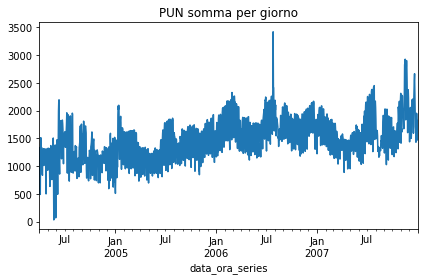

In [ ]:
serie_2004_2007.PUN.resample('D').sum().plot(title='PUN somma per giorno')
plt.tight_layout()
plt.show()

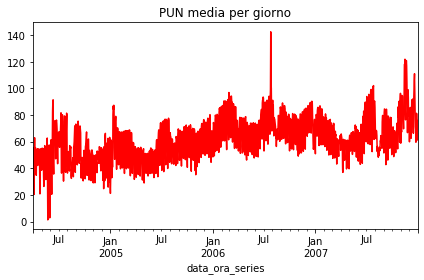

In [ ]:
serie_2004_2007.PUN.resample('D').mean().plot(title='PUN media per giorno',color='red')
plt.tight_layout()
plt.show()

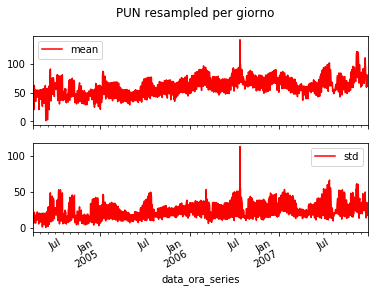

In [ ]:
r2 = serie_2004_2007.PUN.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='PUN resampled per giorno', color='red')
plt.show()

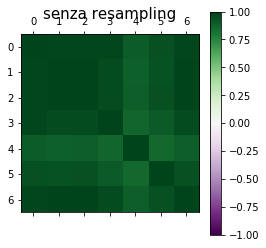

In [ ]:
# Correlations among columns
plt.matshow(serie_2004_2007.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('senza resampling', size=15)
plt.colorbar()
plt.show()

In [ ]:
type(serie_2004_2007)

pandas.core.frame.DataFrame

In [ ]:
n_vars = serie_2004_2007.shape[1]

In [ ]:
print(n_vars)

7


In [ ]:
values = serie_2004_2007.values

In [ ]:
type(values) #numpy.ndarray

In [ ]:
values = values.astype('float32')

In [ ]:
import os
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
scaled = scaler.fit_transform(values)

In [ ]:
reframed = series_to_supervised(scaled, 1, 1)

In [ ]:
print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  ...   var5(t)  var6(t)   var7(t)
1       0.086479   0.083350   0.083350  ...  0.124375  0.06050  0.087500
2       0.091029   0.087500   0.087500  ...  0.124375  0.06102  0.080650
3       0.084685   0.080650   0.080650  ...  0.124375  0.06088  0.077725
4       0.081926   0.077725   0.077725  ...  0.124375  0.06000  0.075000
5       0.079299   0.075000   0.075000  ...  0.124375  0.06042  0.075525
...          ...        ...        ...  ...       ...      ...       ...
32872   0.231463   0.209125   0.209125  ...  0.226769  0.29174  0.209125
32873   0.231614   0.209125   0.209125  ...  0.227806  0.29174  0.209850
32874   0.232368   0.209850   0.209850  ...  0.213510  0.16152  0.199850
32875   0.209081   0.199850   0.199850  ...  0.192066  0.14800  0.184850
32876   0.193035   0.184850   0.184850  ...  0.170622  0.13588  0.169850

[32876 rows x 14 columns]


In [ ]:
# per ora consideriamo solo il PUN
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
values = reframed.values

In [ ]:
n_train_time = 365*24

In [ ]:
train = values[:n_train_time, :]

In [ ]:
test = values[n_train_time:, :]

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [ ]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 7) (8760,) (24116, 1, 7) (24116,)


In [ ]:
n_timesteps = train_X[1]
n_features = train_X[2]

In [ ]:
 print(train_y.shape[1])

In [ ]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [ ]:
model = Sequential()
model.add(LSTM(200, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 200)            166400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 200)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 487,401
Trainable params: 487,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 24116 samples
Epoch 1/20
 - 16s - loss: 0.0019 - val_loss: 0.0020
Epoch 2/20
 - 14s - loss: 0.0016 - val_loss: 0.0021
Epoch 3/20
 - 14s - loss: 0.0015 - val_loss: 0.0022
Epoch 4/20
 - 14s - loss: 0.0015 - val_loss: 0.0021
Epoch 5/20
 - 14s - loss: 0.0015 - val_loss: 0.0022
Epoch 6/20
 - 14s - loss: 0.0015 - val_loss: 0.0022
Epoch 7/20
 - 14s - loss: 0.0015 - val_loss: 0.0024
Epoch 8/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 9/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 10/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 11/20
 - 14s - loss: 0.0015 - val_loss: 0.0024
Epoch 12/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 13/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 14/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 15/20
 - 14s - loss: 0.0015 - val_loss: 0.0023
Epoch 16/20
 - 14s - loss: 0.0015 - val_loss: 0.0024
Epoch 17/20
 - 13s - loss: 0.0015 - val_loss: 0.0024
Epoch 18/20
 - 13s - loss: 0.0015 - val_loss: 0.0023
Epoch 